# Vision Transformer (ViT) -Feature Extraction Cifar10

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tensorchiefs/dl_course_2025/blob/master/notebooks/10_vit_feature_extraction.ipynb)

In this notebook you will finetune a pretrained Vision Transformer for a downstream task.
Models pretrained on large datasets are also called Foundation models, since they can be used for many different tasks.

Note that this Notebook is entirely pytorch based and serves the purpose to show how a vit compares to the CNN on the CIFAR10 DATASET

**Dataset**
- Pretrained model was trained on : Imagenet 14'197'122 images - 1000 Classes. 
- CIFAR 10 There are 60'000 32x32 pixel color images of 10 classes ("airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck")


**Content**
1.   Load a pretrained VisionTransfomer model
2.   Freeze the Encoder, exctract features and visualize them with TSNE
3.   Train the MLP Head 
4.   Compare with previous Performance

Imagenet: https://www.image-net.org/about.php
VisionTransformer: https://arxiv.org/abs/2010.11929


-------

In [ ]:
# @title imports & helperfunctions
# imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms

from timm import create_model # troch image models

import numpy as np

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE



# Configuration
model_name = "vit_base_patch16_224"
batch_size = 64
epochs = 10
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)


### 1. Data Preparation
# Data Augmentation and Normalization
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize CIFAR-10 images to 224x224
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

# Load CIFAR-10 dataset, already included in torchvision 
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

@torch.no_grad()
def extract_features(loader, model, device):
    features = []
    labels   = []
    for images, targets in loader:
        images = images.to(device)
        # VisionTransformer in timm: forward(x) now calls forward_features + head,
        # but since head is Identity it’s just the feature vector.
        feats = model(images)
        features.append(feats.cpu())
        labels.append(targets)
    features = torch.cat(features, dim=0)  # shape [N, embed_dim]
    labels   = torch.cat(labels,   dim=0)
    return features.numpy(), labels.numpy()

Device: cuda


1.    instantiate a model and set the classification head to identity
2.    extract the features of the testset with this model
3.   visulalze these features with a dimensionalyt reduction method such as TSNE

## 1 & 2 Load a model an visualize Features from the encoder

1. Create Model
2. Extracting features from test set…
Features shape: (10000, 768), Labels shape: (10000,)
 3. Running t-SNE...
t-SNE complete. Output shape: (10000, 2)


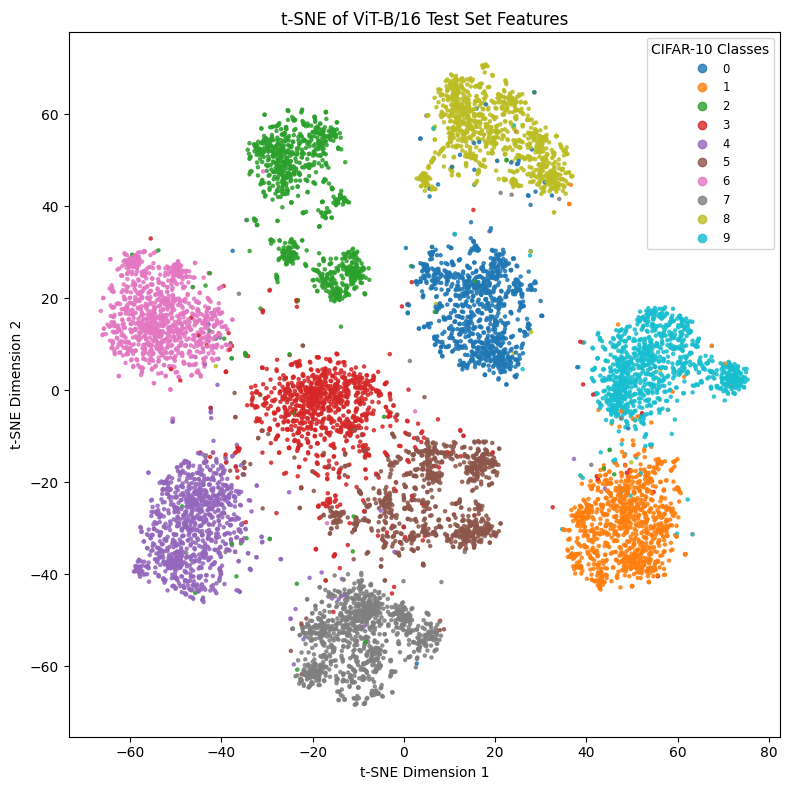

CPU times: user 5min 25s, sys: 3.59 s, total: 5min 28s
Wall time: 1min


In [3]:
%%time
## 1.
print("1. Create Model")
model = create_model(model_name, pretrained=True, num_classes=10)  # CIFAR-10 has 10 classes
model.reset_classifier(0)  # timm will replace the head with nn.Identity()
model = model.to(device)
model.eval()

## 2.
print("2. Extracting features from test set…")
test_feats, test_labels = extract_features(test_loader, model, device)
print(f"Features shape: {test_feats.shape}, Labels shape: {test_labels.shape}")

## 3. 
print(" 3. Running t-SNE...")
tsne = TSNE(n_components=2,perplexity=30,learning_rate=200,max_iter=1000,random_state=42,init='pca')
features_2d = tsne.fit_transform(test_feats)
print("t-SNE complete. Output shape:", features_2d.shape)

# plot the tsne with 2 dims
plt.figure(figsize=(8, 8))
scatter = plt.scatter(features_2d[:, 0],features_2d[:, 1],c=test_labels,cmap='tab10',s=5,alpha=0.8)
plt.title("t-SNE of ViT-B/16 Test Set Features");plt.xlabel("t-SNE Dimension 1");plt.ylabel("t-SNE Dimension 2")
plt.legend(*scatter.legend_elements(num=10),title="CIFAR-10 Classes",loc="best",fontsize="small")
plt.tight_layout()
plt.show()

- see that the pretrained model finds distinguishable features for the 10 classes

## 3. Train only the MLP head

This is equvalent to freeze the encoder, if we use the features directly and feed them to an MLP head

1.) extract the features with the encoder

2.) Define a  little MLP with 32 neurons in the hidden layer

3.) Dataloader with features, model instance 

4.) Train for some eps

1. Extracting features from train set…
 2. Create Tensordataset
 3. Instantiate model
 4. Train model on extracted features
Epoch  1 | Train Loss: 0.6474, Train Acc: 0.8643 | Test  Loss: 0.1165, Test  Acc: 0.9692
Epoch  2 | Train Loss: 0.1005, Train Acc: 0.9724 | Test  Loss: 0.0842, Test  Acc: 0.9756
Epoch  3 | Train Loss: 0.0776, Train Acc: 0.9783 | Test  Loss: 0.0644, Test  Acc: 0.9814
Epoch  4 | Train Loss: 0.0646, Train Acc: 0.9813 | Test  Loss: 0.0518, Test  Acc: 0.9859
Epoch  5 | Train Loss: 0.0518, Train Acc: 0.9868 | Test  Loss: 0.0440, Test  Acc: 0.9880
Epoch  6 | Train Loss: 0.0468, Train Acc: 0.9866 | Test  Loss: 0.0386, Test  Acc: 0.9902
Epoch  7 | Train Loss: 0.0380, Train Acc: 0.9897 | Test  Loss: 0.0299, Test  Acc: 0.9939
Epoch  8 | Train Loss: 0.0320, Train Acc: 0.9924 | Test  Loss: 0.0275, Test  Acc: 0.9936
Epoch  9 | Train Loss: 0.0265, Train Acc: 0.9934 | Test  Loss: 0.0222, Test  Acc: 0.9956
Epoch 10 | Train Loss: 0.0233, Train Acc: 0.9951 | Test  Loss: 0.0190, Test

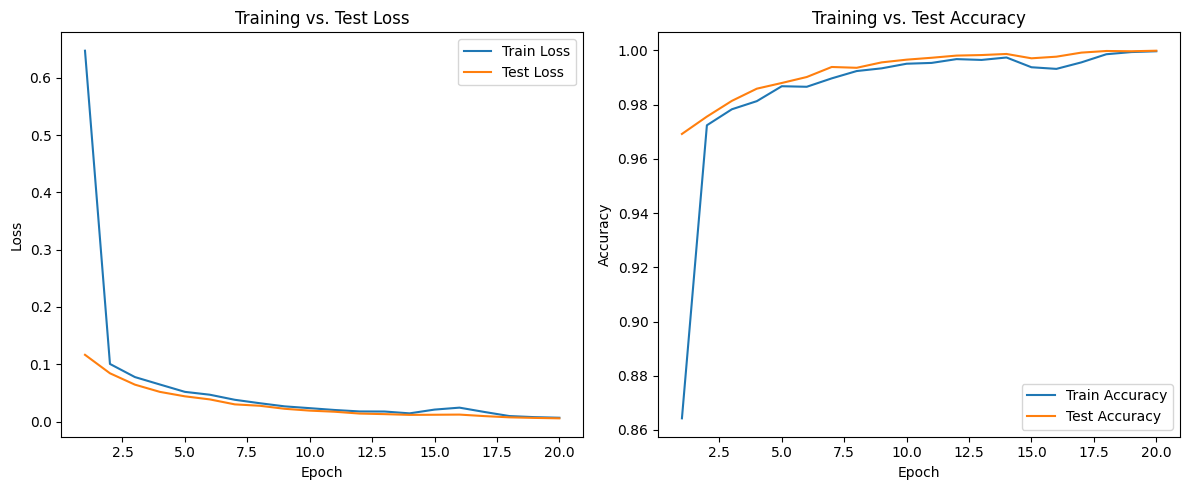

CPU times: user 2min 10s, sys: 3.52 s, total: 2min 14s
Wall time: 44.3 s


In [ ]:
%%time
# 1) create a model with no learnable weights in the output, and extract features fro train data
print("1. Extracting features from train set…")
model = create_model(model_name, pretrained=True, num_classes=10)  # CIFAR-10 has 10 classes
model.reset_classifier(0)  # timm will replace the head with nn.Identity()
model = model.to(device)
model.eval()
train_feats, train_labels = extract_features(test_loader, model, device)

print("2. Create Tensordataset")
# 2) DataLoader setup
batch_size = 256
train_ds = TensorDataset(torch.Tensor(train_feats), torch.Tensor(train_labels).long())
test_ds  = TensorDataset(torch.Tensor(test_feats),  torch.Tensor(test_labels).long())

train_features_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_features_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("3. Instantiate model")
# 3) MLP definition
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, num_classes)
        )
    def forward(self, x):
        return self.net(x)

model = MLP(input_dim=train_feats.shape[1], hidden_dim=32, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("4. Train model on extracted features")
# 4) Training loop with history logging
num_epochs = 20
train_losses, test_losses = [], []
train_accs,   test_accs   = [], []

for epoch in range(1, num_epochs + 1):
    # — Train —
    model.train()
    running_loss = correct = total = 0
    for feats, targets in train_features_loader:
        feats, targets = feats.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(feats)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * feats.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += feats.size(0)
    train_loss = running_loss / total
    train_acc  = correct / total

    # — Eval on test set —
    model.eval()
    running_loss = correct = total = 0
    with torch.no_grad():
        for feats, targets in test_features_loader:
            feats, targets = feats.to(device), targets.to(device)
            outputs = model(feats)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * feats.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == targets).sum().item()
            total += feats.size(0)
    test_loss = running_loss / total
    test_acc  = correct / total

    # Record metrics
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch {epoch:2d} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test  Loss: {test_loss:.4f}, Test  Acc: {test_acc:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Left subplot: Loss
axes[0].plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
axes[0].plot(range(1, num_epochs + 1), test_losses,  label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training vs. Test Loss')
axes[0].legend()
# Right subplot: Accuracy
axes[1].plot(range(1, num_epochs + 1), train_accs, label='Train Accuracy')
axes[1].plot(range(1, num_epochs + 1), test_accs,  label='Test Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training vs. Test Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

## 4.   Compare with previous Performance




How does the performance compare to the models from notebook: "cifar10 tricks" ?
to your own models performance?

| Model Configuration                           | Accuracy |
|-----------------------------------------------|---------:|
| RF on pixel values                            |   0.3930 |
| CNN from scratch without normalization        |   0.1000 |
| CNN from scratch with normalization           |   0.5971 |
| CNN from scratch with dropout                 |   0.1000 |
| CNN from scratch with batchnorm               |   0.6044 |
| CNN from scratch with data augmentation       |   0.1000 |